In [213]:
# run if ModuleNotFoundError occurs, then use the path output to install modules
import sys
print(sys.executable) 

/usr/local/Cellar/jupyterlab/3.0.14/libexec/bin/python3.9


### Functions for Data Loading and Plotting

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import math, random
import scipy.optimize
import scipy.stats as stats
import seaborn as sns
import re

sns.set(font_scale=1.2, style="whitegrid")
plt.rcParams['figure.figsize'] = [7.0, 4.0]

def load_benchmark(filename):
    data = []
    row = [0, 0, 0, 0, 0, 0, 0]
    n = 0
    m = 0
    with open(filename, "r") as f:
        for line in f:
            words = line.split(" ")
            if line.startswith("n="):
                n = int(words[0].replace("n=", ""))
            elif line.startswith("m="):
                m = int(words[0].replace("m=", ""))
            elif line.startswith("Switches successful:"):
                row = [0, 0, 0, 0, 0, n, m]
                row[0] = float(words[2].replace("%", ""))
            elif line.startswith("Runtime + Initialization:"):
                row[1] = float(words[3].replace("s", ""))
            elif line.startswith("Switches per second:"):
                row[2] = float(words[3].replace("M", ""))
            elif line.startswith("Runtime for 10m successful switches + Initialization:"):
                row[3] = float(words[7].replace("s", ""))
                data.append(row)
            elif line.startswith("Runtime:"):
                row[4] = float(words[1].replace("s", ""))
    data = pd.DataFrame(data, columns=["ss", "rt", "sps", "ert", "rt2", "n", "m"])
    return data

def fieller_ci(a_series, b_series, alpha=0.05):
    a = a_series.mean()
    b = b_series.mean()
    a_var = a_series.std() * a_series.std()
    b_var = b_series.std() * b_series.std()
    a_b_cov = a_series.cov(b_series)
    ratio = a / b
    df = a_series.size + b_series.size - 2
    _, t = stats.t.interval(1 - alpha, df)
    s = math.sqrt((a_series / b_series).std())
    g = (t * t * s * s * b_var) / (b * b)
    if g >= 1:
        return None, None
    ratio_std = (s / b) * math.sqrt(a_var - (2 * ratio * a_b_cov) + (ratio * ratio * b_var) - g * (a_var - (a_b_cov * a_b_cov) / b_var))
    lower = (1 / (1 - g)) * (ratio - g * (a_b_cov / b_var) - t * ratio_std)
    upper = (1 / (1 - g)) * (ratio - g * (a_b_cov / b_var) + t * ratio_std)
    return lower, upper

def taylor_ci(a_series, b_series, alpha=0.05):
    a = a_series.mean()
    b = b_series.mean()
    a_var = a_series.std() * a_series.std()
    b_var = b_series.std() * b_series.std()
    a_b_cov = a_series.cov(b_series)
    ratio = a / b
    df = a_series.size + b_series.size - 2
    _, t = stats.t.interval(1 - alpha, df)
    ratio_std = ratio * math.sqrt(a_var / (a * a) + b_var / (b * b) - 2 * a_b_cov / (a * b))
    lower = ratio - t * ratio_std
    upper = ratio + t * ratio_std
    return lower, upper

### Sequential

In [215]:
#data_dir = "benchmark-results/sequential/"
#graphs = ["soc-twitter-mpi-sws", "bn-human-Jung2015_M87100374", "tech-p2p", "socfb-konect", "ca-hollywood-2009", "inf-road-usa", "bio-human-gene1", "web-wikipedia2009", "cit-HepTh", "email-enron-large", "rec-amazon"]
#algos = ["networkit", "gengraph", "robin-v2", "global-robin", "naive-v2", "global-naive-v2", "global-no-wait"]
#plot_sequential_scatter(data_dir, graphs, algos, 10, 1)

In [216]:
#data_dir = "benchmark-results/parallel/"
#graphs = ["soc-twitter-mpi-sws", "bn-human-Jung2015_M87100374", "tech-p2p", "socfb-konect", "ca-hollywood-2009", "inf-road-usa", "bio-human-gene1", "web-wikipedia2009", "cit-HepTh", "email-enron-large", "rec-amazon"]
#algos = ["naive-v2", "global-naive-v2", "global-no-wait"]
#plot_sequential_scatter(data_dir, graphs, algos, 10, 32)

### Scaling in p

In [217]:
def plot_comparison(names, prange, spe, title):
    initialized = False
    data = None
    for name in names:
        file_name = "bn-human-Jung2015_M87100374" if name == "bn-human-Jung2015" else name
        sequential_g = load_benchmark(par_dir + file_name + "_global-no-wait-no-prefetch_" + str(spe) + "_1")
        for p in prange:
            for algo in ["global-no-wait-no-prefetch"]:
                sequential = sequential_g # if algo in else
                parallel = load_benchmark(par_dir + file_name + "_" + algo + "_" + str(spe) + "_" + str(p))
                speedup = sequential.rt.mean() / parallel.rt.mean()
                if p == 1:
                    lower, upper = speedup, speedup
                else:
                    lower, upper = fieller_ci(sequential.rt, parallel.rt)
                if lower == None or upper == None:
                    print("err: " + str(p) + " " + algo)
                if algo == "global-no-wait-no-prefetch":
                    algo_name = "$\mathtt{SP-GES}$"
                data_algo_p = pd.DataFrame([[name, algo_name, name + algo_name, p, speedup, lower, upper]], columns=["Graph", "Algorithm", "Key", "PUs", "speedup", "lower", "upper"])
                if not initialized:
                    data = data_algo_p
                    initialized = True
                else:
                    data = pd.concat([data, data_algo_p])
    fig, ax = plt.subplots()
    algo_colors = ["$\mathtt{SP-GES}$"]
    g_results=sns.lineplot(x="PUs", y="speedup", data=data, hue="Graph", palette="deep")
    for name in names:
        for algo in algo_colors:
            ax.fill_between(x=data.loc[data["Key"] == name + algo, "PUs"],
                            y1=data.loc[data["Key"] == name + algo, "lower"],
                            y2=data.loc[data["Key"] == name + algo, "upper"], alpha=0.2)
    ax.set_xticks(list(range(2, 68, 6)))
    ax.set_yticks(list(range(2, 34, 4)))
    #ax.axhline(1, color="red", ls='--')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[0:], labels=labels[0:], bbox_to_anchor=(1.02, 1.01), loc=2, borderaxespad=0., ncol=1)
    #plt.legend(bbox_to_anchor=(1.05, 1.03), loc=2, borderaxespad=0., ncol=2)
    g_results.set(xlabel='number of PUs $\mathcal{P}$', ylabel='self speed-up')
    g_results.get_figure().savefig("figures/" + str(title) + ".pdf", format='pdf', dpi=1200, bbox_inches="tight")

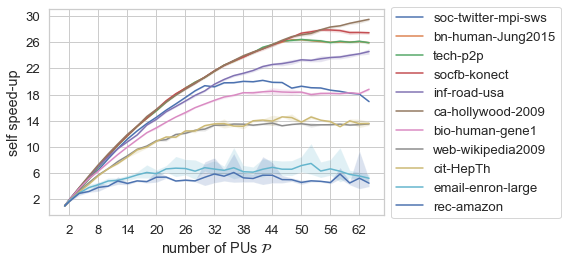

In [218]:
par_dir = "benchmark-results/scaling-p/"
sns.set(font_scale=1.2, style="whitegrid")
plt.rcParams['figure.figsize'] = [6.0, 3.8]
graphs = ["soc-twitter-mpi-sws", "bn-human-Jung2015", "tech-p2p", "socfb-konect", "inf-road-usa", "ca-hollywood-2009", "bio-human-gene1", "web-wikipedia2009", "cit-HepTh", "email-enron-large", "rec-amazon"]
plot_comparison(graphs, [1] + list(range(2, 66, 2)), 10, "scaling-p-netrep-sample")

In [223]:
def plot_scaling_avgd(names, prange, spe, title):
    initialized = False
    data = None
    for name in names:
        for p in prange:
            for algo in ["global-no-wait-no-prefetch"]:
                parallel = load_benchmark(par_dir + name + "_" + algo + "_" + str(spe) + "_" + str(p))
                n = parallel.n.mean()
                m = parallel.m.mean()
                if m < 300000:
                    m_name = "$m = 2^{18}$"
                elif m < 2000000:
                    m_name = "$m = 2^{20}$"
                elif m < 5000000:
                    m_name = "$m = 2^{22}$"
                elif m < 20000000:
                    m_name = "$m = 2^{24}$"
                elif m < 80000000:
                    m_name = "$m = 2^{26}$"
                elif m < 320000000:
                    m_name = "$m = 2^{28}$"
                elif m < 1200000000:
                    m_name = "$m = 2^{30}$"
                if algo == "global-no-wait-no-prefetch":
                    algo_name = "$\mathtt{SP-GES}$"
                avg_d = (2 * parallel.m.mean()) // parallel.n.mean()
                #print(name, avg_d)
                if avg_d < 20:
                    avg_d_name = "32"
                elif avg_d < 100:
                    avg_d_name = "128"
                elif avg_d < 300:
                    avg_d_name = "512"
                elif avg_d < 2000:
                    avg_d_name = "2048"
                data_algo_p = parallel
                data_algo_p["avg-d"] = avg_d
                data_algo_p["Algorithm"] = algo_name
                data_algo_p["edges"] = m_name
                data_algo_p["PUs"] = "$\mathcal{P} = 64$" if p == 64 else "$\mathcal{P} = 32$"
                if not initialized:
                    data = data_algo_p
                    initialized = True
                else:
                    data = pd.concat([data, data_algo_p])
    fig, ax = plt.subplots()
    hues = ["$m = 2^{28}$", "$m = 2^{26}$", "$m = 2^{24}$", "$m = 2^{22}$", "$m = 2^{20}$", "$m = 2^{18}$"]
    styles = ["$\mathcal{P} = 64$", "$\mathcal{P} = 32$"]
    g_results=sns.lineplot(x="avg-d", y="rt", data=data, hue="edges", hue_order=hues, style="PUs", style_order=styles, palette="deep")
    ax.set_xscale("log")
    ax.set_xticks([10, 100, 1000, 10000])
    ax.set_yscale("log")
    ax.set_yticks([0.1, 1, 10, 100])#, 1000])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(bbox_to_anchor=(1.02, 1.0), loc=2, borderaxespad=0., ncol=1)
    g_results.set(xlabel='average degree', ylabel='runtime (seconds)')
    g_results.get_figure().savefig("figures/" + str(title) + ".pdf", format='pdf', dpi=1200, bbox_inches="tight")

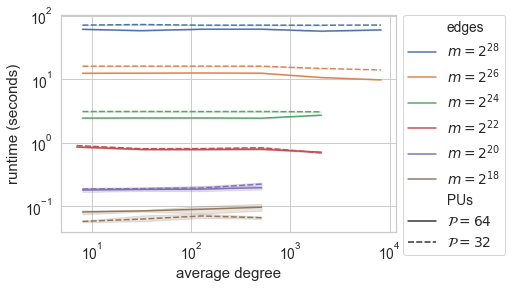

In [224]:
par_dir = "benchmark-results/scaling-avg-d/"
sns.set(font_scale=1.25, style="whitegrid")
plt.rcParams['figure.figsize'] = [6.0, 4.0]
graphs = ["random_16_4", "random_18_4", "random_20_4", "random_22_4", "random_24_4", "random_26_4",
          "random_14_16", "random_16_16", "random_18_16", "random_20_16", "random_22_16", "random_24_16",
          "random_12_64", "random_14_64", "random_16_64", "random_18_64", "random_20_64", "random_22_64",
          "random_10_256", "random_12_256", "random_14_256", "random_16_256", "random_18_256", "random_20_256",
          "random_12_1024", "random_14_1024", "random_16_1024", "random_18_1024",
          "random_14_4096", "random_16_4096", "random_18_4096"]
plot_scaling_avgd(graphs, [32, 64], 10, "scaling-avg-d")

In [231]:
def plot_scaling_gamma(names, prange, spe, title):
    initialized = False
    data = None
    for name in names:
        for p in prange:
            for i in range(1, 6):
                algo = "global-no-wait-no-prefetch"
                parallel = load_benchmark(par_dir + name + "_" + str(i) + "_" + algo + "_" + str(spe) + "_" + str(p))
                n = parallel.n.mean()
                m = parallel.m.mean()
                if m < 300000:
                    m_name = "$m = 2^{18}$"
                elif m < 2000000:
                    m_name = "$m = 2^{20}$"
                elif m < 5000000:
                    m_name = "$m = 2^{22}$"
                elif m < 20000000:
                    m_name = "$m = 2^{24}$"
                elif m < 80000000:
                    m_name = "$m = 2^{26}$"
                elif m < 320000000:
                    m_name = "$m = 2^{28}$"
                if algo == "global-no-wait-no-prefetch":
                    algo_name = "$\mathtt{SP-GES}$"
                gamma = float(name.split("_")[2])
                data_algo_p = parallel
                data_algo_p["gamma"] = gamma
                data_algo_p["Algorithm"] = algo_name
                data_algo_p["nodes"] = "$n=2^{" + str(int(math.log2(n))) + "}$"
                data_algo_p["PUs"] = "$\mathcal{P} = 64$" if p == 64 else "$\mathcal{P} = 32$"
                data_algo_p["rt"] /= m
                if not initialized:
                    data = data_algo_p
                    initialized = True
                else:
                    data = pd.concat([data, data_algo_p])
    fig, ax = plt.subplots()
    hues = ["$n=2^{28}$", "$n=2^{26}$", "$n=2^{24}$"]
    styles = ["$\mathcal{P} = 64$", "$\mathcal{P} = 32$"]
    g_results=sns.lineplot(x="gamma", y="rt2", data=data, hue="nodes", hue_order=hues, style="PUs", style_order=styles, palette="deep")
    ax.invert_xaxis()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(bbox_to_anchor=(1.02, 1.0), loc=2, borderaxespad=0., ncol=1)
    g_results.set(xlabel='degree exponent $\gamma$', ylabel='runtime (seconds) / m')
    g_results.get_figure().savefig("figures/" + str(title) + ".pdf", format='pdf', dpi=1200, bbox_inches="tight")

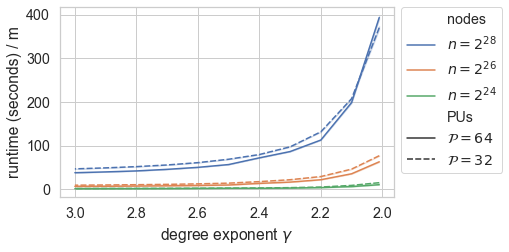

In [232]:
par_dir = "benchmark-results/scaling-gamma/"
sns.set(font_scale=1.3, style="whitegrid")
plt.rcParams['figure.figsize'] = [6.0, 3.5]
ns = [24, 26, 28]
gs = ["3", "2.9", "2.8", "2.7", "2.6", "2.5", "2.4", "2.3", "2.2", "2.2", "2.1", "2.01"]
graphs = ["powerlaw_" + str(n) + "_" + str(g) for n in ns for g in gs]
plot_scaling_gamma(graphs, [32, 64], 10, "scaling-gamma")

## Runtime scatterplot

600.0
601.5


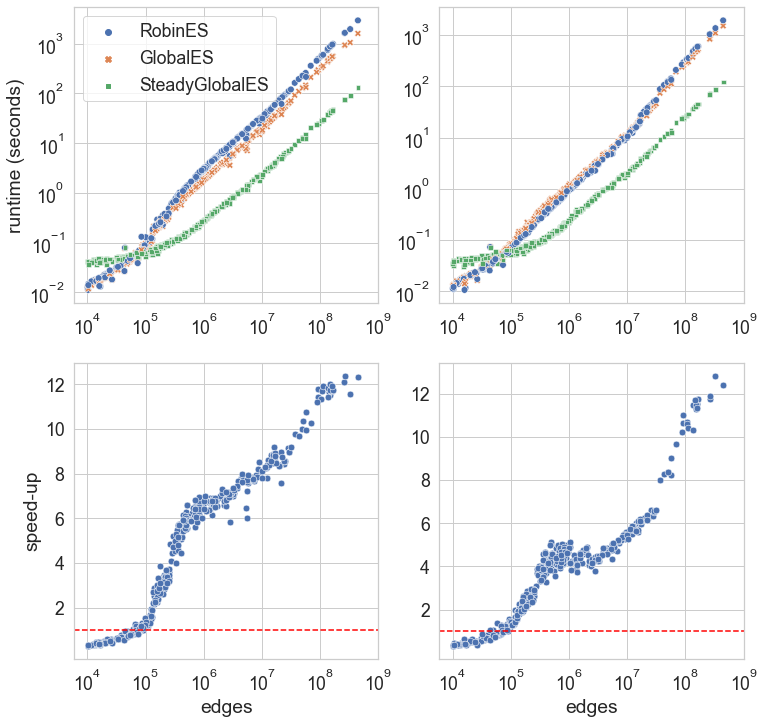

In [180]:
sns.set(font_scale=1.6, style="whitegrid")
plt.rcParams['figure.figsize'] = [12.0, 12.0]

from pathlib import Path

data_dir="benchmark-results/real-world_scatter-no-prefetch/"
max_d_dir="benchmark-results/max-degrees/"
def load_speedup(name, spe, p):
    parallel = load_benchmark(data_dir + name + "_global-no-wait-no-prefetch_" + str(spe) + "_" + str(p))
    sequential = load_benchmark(data_dir + name + "_global-robin-no-prefetch_" + str(spe) + "_1")
    robin = load_benchmark(data_dir + name + "_robin-v2-no-prefetch_" + str(spe) + "_1")
    m = int(sequential.m.mean())
    n = int(sequential.n.mean())
    if Path(max_d_dir + name).exists():
        with Path(max_d_dir + name).open() as f:
            for line in f:
                max_d = int(line)
                max_d = "$d_{max} < n^{1/4}$" if max_d < math.pow(n, 0.25) else "$d_{max} < n^{1/2}$" if max_d < math.pow(n, 0.5) else "$d_{max} \geq n^{1/2}$"
    else:
        max_d = "undef"
    if not m > 0 or not n > 0:
        return None, None
    s = m / n
    d = "$\overline{d} < 10$" if s < 10 else "$\overline{d} < 100$" if s < 100 else "$\overline{d} \geq 100$"
    #n = "$n < 20$" if n < 2**20 else "n < 24$" if n < 2**24 else "$n > 24$"
    return [[sequential.rt.mean(), "GlobalES", max_d, m, n, d],
            [robin.rt.mean(), "RobinES", max_d, m, n, d],
            [parallel.rt.mean(), "SteadyGlobalES", max_d, m, n, d]], [sequential.rt.mean() / parallel.rt.mean(), max_d, m, n, d]

data = []
data2 = []
for category in Path(data_dir).iterdir():
    if not category.is_dir():
        continue
    for result in category.iterdir():
        if "robin-v2-no-prefetch" in result.name:
            graph_name = result.name.replace("_robin-v2-no-prefetch_10_1", "")
            row, speedup = load_speedup(category.name + "/" + graph_name, 10, 32)
            if row == None and speedup == None:
                continue
            if speedup[2] < 10000:
                continue
            data.append(row[0] + [category.name])
            data.append(row[1] + [category.name])
            data.append(row[2] + [category.name])
            data2.append(speedup + [category.name])

data=pd.DataFrame(data, columns=["rt", "Algorithm", "Max Degree", "m", "n", "Density", "Category"])
data2=pd.DataFrame(data2, columns=["speedup", "Max Degree", "m", "n", "Density", "Category"])
print(len(data) / 2)

#colors = ["bio", "bn", "ca", "cit", "eco", "econ", "email", "heter", "ia", "inf",
#          "labeled", "massive", "power", "protein", "proximity", "rec", "road",
#          "retweet_graphs", "sc", "soc", "socfb", "tech", "web"]
algos = ["RobinES", "GlobalES", "SteadyGlobalES"]
colors = ["$d_{max} \geq n^{1/2}$", "$d_{max} < n^{1/2}$", "$d_{max} < n^{1/4}$"]
styles = ["$\overline{d} \geq 100$", "$\overline{d} < 100$", "$\overline{d} < 10$"]

fig, ax = plt.subplots(2, 2)
g_results=sns.scatterplot(data=data, x="m", y="rt", s=45, hue="Algorithm", style="Algorithm", hue_order=algos, style_order=algos, ax=ax[0][0])
g_results=sns.scatterplot(data=data2, x="m", y="speedup", s=45, ax=ax[1][0])# hue="Max Degree", style="Density", hue_order=colors, style_order=styles, ax=ax[1][0])
#g_results.set(xlabel="edges", ylabel='wall time (seconds)')
#plt.legend(bbox_to_anchor=(1.05, 1.03), loc=2, borderaxespad=0., ncol=2)
#plt.legend(ncol=2)
ax[0][0].set_xlabel("")
ax[0][0].set_xscale("log")
ax[0][0].set_xticks([10000, 100000, 1000000, 10000000, 100000000, 1000000000])
ax[0][0].set_ylabel("runtime (seconds)")
ax[0][0].set_yscale("log")
ax[0][0].set_yticks([0.01, 0.1, 1, 10, 100, 1000])
ax[1][0].set_xlabel("edges")
ax[1][0].set_xscale("log")
ax[1][0].set_xticks([10000, 100000, 1000000, 10000000, 100000000, 1000000000])
ax[1][0].set_ylabel("speed-up")
ax[1][0].set_yticks(list(range(2, 14, 2)))
ax[1][0].axhline(1, color="red", ls='--')
handles, labels = ax[0][0].get_legend_handles_labels()
ax[0][0].legend(handles=handles[0:], labels=labels[0:])
#handles, labels = ax[1][0].get_legend_handles_labels()
#ax[1][0].legend(handles=handles[1:4], labels=labels[1:4])

data_dir="benchmark-results/real-world_scatter/"
def load_speedup(name, spe, p):
    parallel = load_benchmark(data_dir + name + "_global-no-wait_" + str(spe) + "_" + str(p))
    sequential = load_benchmark(data_dir + name + "_global-robin_" + str(spe) + "_1")
    robin = load_benchmark(data_dir + name + "_robin-v2_" + str(spe) + "_1")
    m = int(sequential.m.mean())
    n = int(sequential.n.mean())
    if Path(max_d_dir + name).exists():
        with Path(max_d_dir + name).open() as f:
            for line in f:
                max_d = int(line)
                max_d = "$d_{max} < n^{1/4}$" if max_d < math.pow(n, 0.25) else "$d_{max} < n^{1/2}$" if max_d < math.pow(n, 0.5) else "$d_{max} \geq n^{1/2}$"
    else:
        max_d = "undef"
    #speedup = sequential.ert.mean() / parallel.ert.mean()
    #lower, upper = fieller_ci(sequential.rt, parallel.rt)
    if not m > 0 or not n > 0:
        return None, None
    s = m / n
    d = "$\overline{d} < 10$" if s < 10 else "$\overline{d} < 100$" if s < 100 else "$\overline{d} \geq 100$"
    return [[sequential.rt.mean(), "GlobalES", max_d, m, n, d], [robin.rt.mean(), "RobinES", max_d, m, n, d],
            [parallel.rt.mean(), "SteadyGlobalES", max_d, m, n, d]], [sequential.rt.mean() / parallel.rt.mean(), max_d, m, n, d]

data = []
data2 = []
for category in Path(data_dir).iterdir():
    if not category.is_dir():
        continue
    for result in category.iterdir():
        if "robin-v2" in result.name:
            graph_name = result.name.replace("_robin-v2_10_1", "")
            row, speedup = load_speedup(category.name + "/" + graph_name, 10, 32)
            if row == None and speedup == None:
                continue
            #if row[3] > 0:
            #    ms.append(row[3])
            #    data.append(row + [category.name])
            if speedup[2] < 10000:
                continue
            data.append(row[0] + [category.name])
            data.append(row[1] + [category.name])
            data.append(row[2] + [category.name])
            data2.append(speedup + [category.name])

data=pd.DataFrame(data, columns=["rt", "Algorithm", "Max Degree", "m", "n", "Density", "Category"])
data2=pd.DataFrame(data2, columns=["speedup", "Max Degree", "m", "n", "Density", "Category"])
print(len(data) / 2)

#colors = ["bio", "bn", "ca", "cit", "eco", "econ", "email", "heter", "ia", "inf",
#          "labeled", "massive", "power", "protein", "proximity", "rec", "road",
#          "retweet_graphs", "sc", "soc", "socfb", "tech", "web"]

#plt.rcParams['figure.figsize'] = [6.0, 12.0]
#fig, ax = plt.subplots(2, 1)
g_results=sns.scatterplot(data=data, x="m", y="rt", s=45, hue="Algorithm", style="Algorithm", hue_order=algos, style_order=algos, ax=ax[0][1])
g_results=sns.scatterplot(data=data2, x="m", y="speedup", s=45, ax=ax[1][1])#hue="Max Degree", style="Density", hue_order=colors, style_order=styles, ax=ax[1][1])
#g_results.set(xlabel="edges", ylabel='wall time (seconds)')
#plt.legend(bbox_to_anchor=(1.05, 1.03), loc=2, borderaxespad=0., ncol=2)
#plt.legend(ncol=2)
ax[0][1].set_xlabel("")
ax[0][1].set_xscale("log")
ax[0][1].set_xticks([10000, 100000, 1000000, 10000000, 100000000, 1000000000])
ax[0][1].set_ylabel("")
ax[0][1].set_yscale("log")
ax[0][1].set_yticks([0.01, 0.1, 1, 10, 100, 1000])
ax[0][1].legend([], [], frameon=False)
ax[1][1].set_xlabel("edges")
ax[1][1].set_xscale("log")
ax[1][1].set_xticks([10000, 100000, 1000000, 10000000, 100000000, 1000000000])
ax[1][1].set_ylabel("")
ax[1][1].set_yticks(list(range(2, 14, 2)))
ax[1][1].axhline(1, color="red", ls='--')
#handles, labels = ax[1][1].get_legend_handles_labels()
#ax[1][1].legend(handles=handles[5:], labels=labels[5:], loc=2)

g_results.get_figure().savefig("figures/real-world_scatter.pdf", format='pdf', dpi=1200, bbox_inches="tight")